In [2]:
import os
import ast
import math
import random
import pickle
import numpy as np
import pandas as pd
from numpy import std
from numpy import nan
from numpy import mean
from scipy.spatial import distance

In [3]:
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [4]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from genetic_selection import GeneticSelectionCV as GA
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare Data

In [5]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
origin = pd.read_csv('origin.csv')
origin_TDM = pd.read_csv('5_TDM_origin.csv')
origin_CON = pd.read_csv('5_CON_origin.csv')

In [7]:
con_cols = pd.read_csv('pathogens.csv')
con_cols = con_cols.columns.tolist()
con_cols.extend(['Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
con_cols.insert(0, 'Visite_day')
con_cols.insert(0, 'rno')

In [8]:
train = train[con_cols]
test = test[con_cols]
origin = origin[con_cols]
origin_TDM = origin_TDM[con_cols]
origin_CON = origin_CON[con_cols]

In [7]:
train_X = train.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
train_y = train[['Sofa']]
train_pat = train[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
test_X = test.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
test_y = test[['Sofa']]
test_pat = test[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
origin_X = origin.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
origin_y = origin[['Sofa']]
origin_pat = origin[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
originTDM_X = origin_TDM.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
originTDM_y = origin_TDM[['Sofa']]
originTDM_pat = origin_TDM[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
originCON_X = origin_CON.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
originCON_y = origin_CON[['Sofa']]
originCON_pat = origin_CON[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]

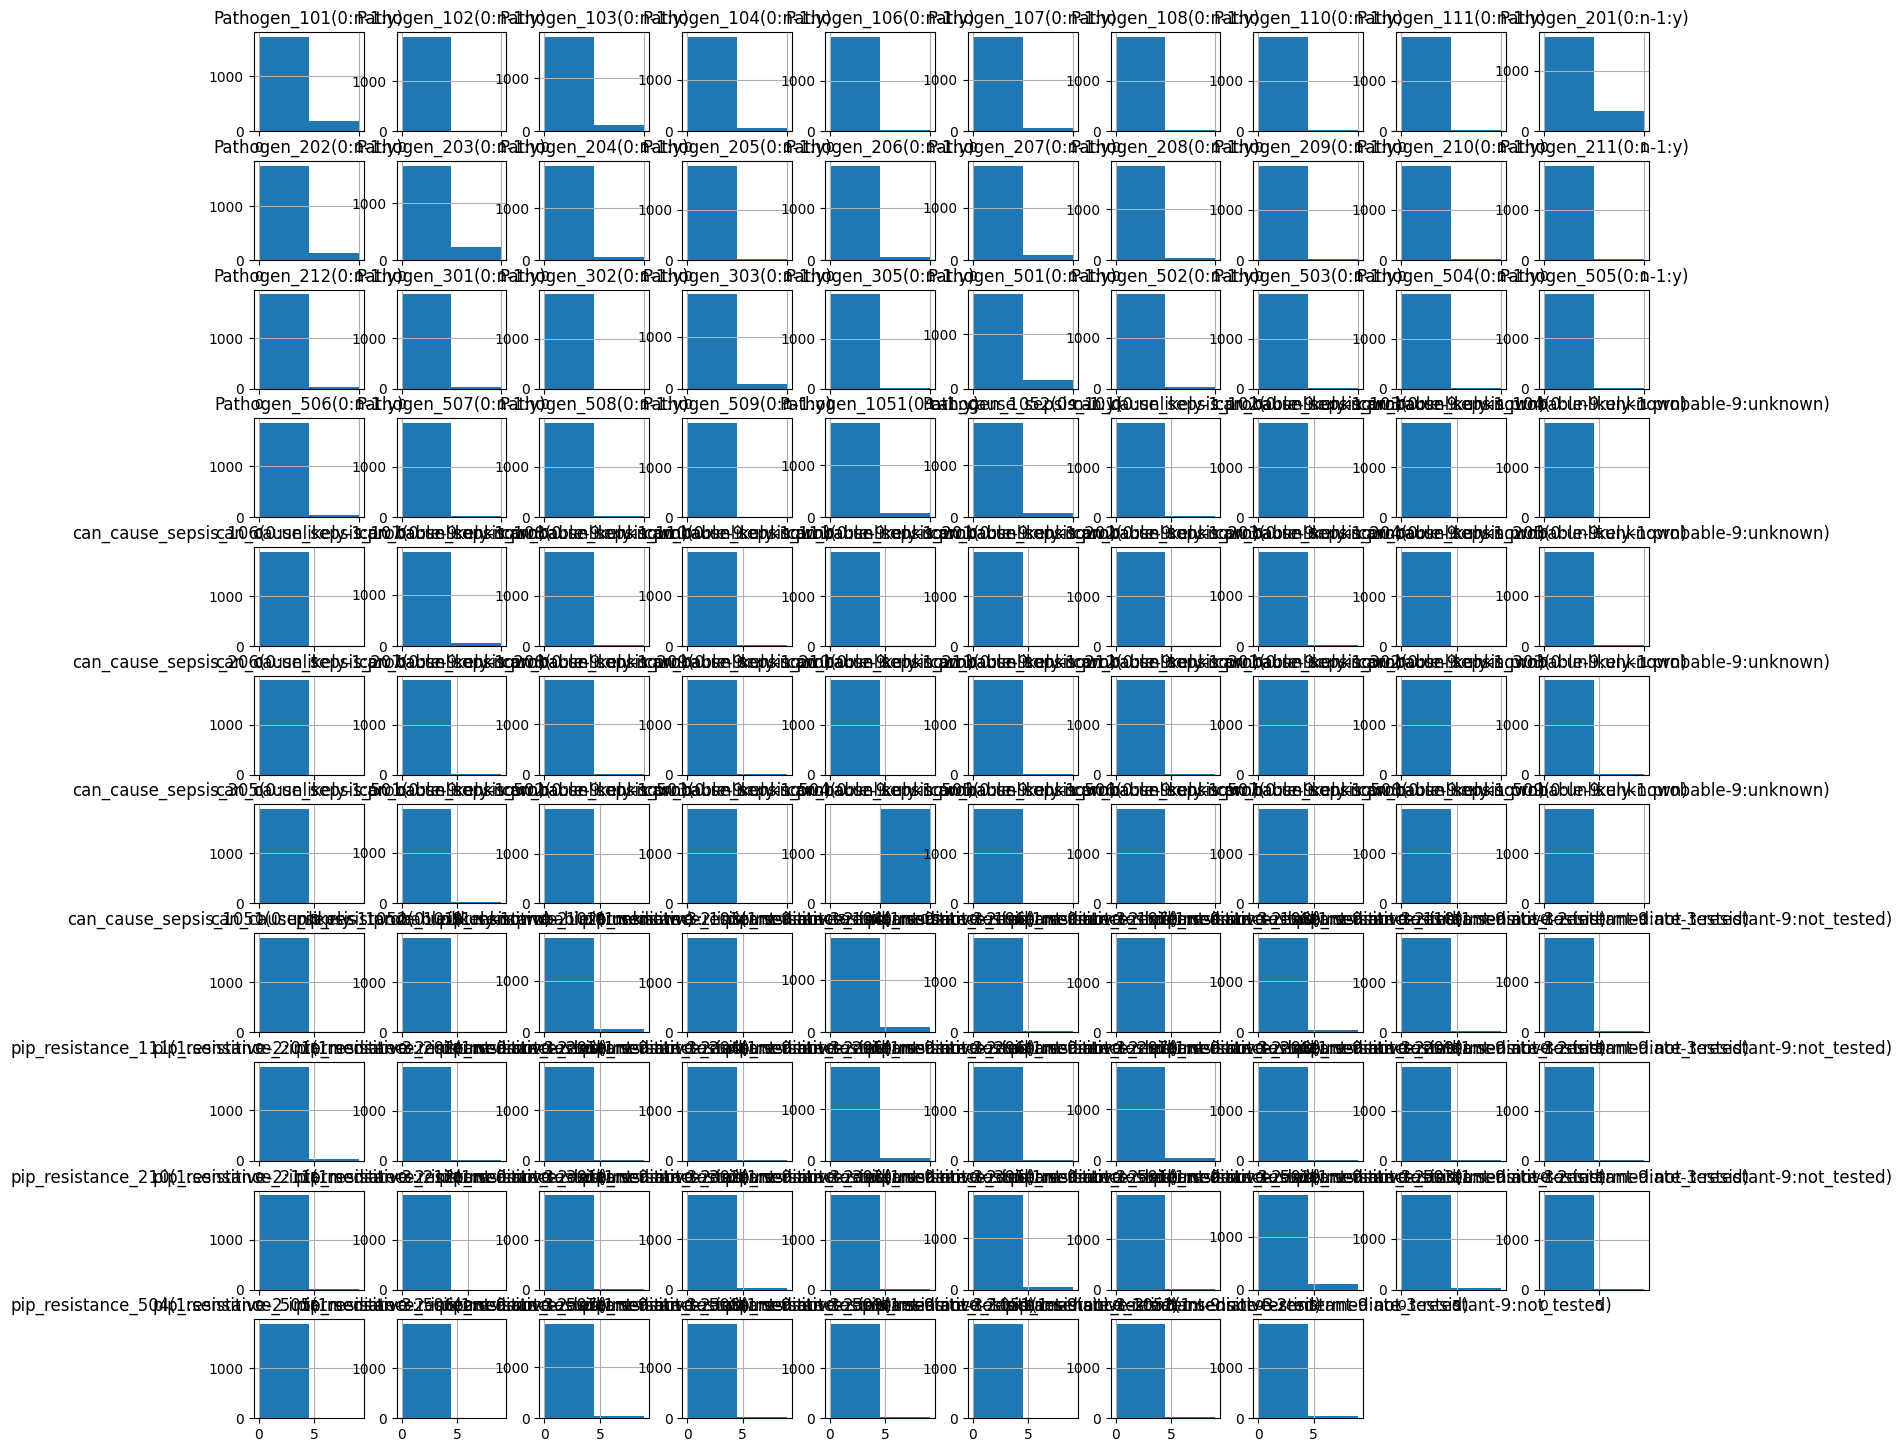

In [8]:
train_X.hist(bins=2, figsize=(18,18))
plt.show()

In [9]:
train_y.hist(bins=15, figsize=(6,6))
plt.show()

In [10]:
correlationMatrix = train_X.corr() 
f = plt.figure(figsize=(15, 15))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(train_X.shape[1]), train_X.columns, fontsize=14, rotation=90)
plt.yticks(range(train_X.shape[1]), train_X.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

# Feature Selection GA

In [11]:
X = train_X
y = train_y
y = y.astype('float')
estimator = RandomForestRegressor()
# evaluate the models and store results
results = []
names = []
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for i in range(1, 37):
    model = GA(estimator, cv=5, verbose=1, scoring='neg_mean_absolute_error', max_features=i, n_population=165, 
               crossover_proba=0.5, mutation_proba=0.05, n_generations=100, crossover_independent_proba=0.5, 
               mutation_independent_proba=0.04, tournament_size=3, n_gen_no_change=10, caching=True, n_jobs=-1)
    model = model.fit(X, y)
    X_selection = X[X.columns[model.support_].tolist()]
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(RandomForestRegressor(), X_selection, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    results.append(scores)
    names.append(i)
    print('>%s %.3f (%.3f)' % (i, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.figure(figsize =(12, 9))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.766469  1.        0.211263]	[ 0.0318    0.        0.029919]	[-2.881962  1.        0.164273]	[-2.710575  1.        0.336679]
1  	84    	[-2486.912621     1.054545  2485.003293]	[ 4320.156957     0.66291   4321.254854]	[-10000.            0.            0.164936]	[   -2.710575     6.       10000.      ]
2  	95    	[-3213.978576     1.327273  3212.257384]	[ 4668.142984     1.436172  4669.327002]	[-10000.            0.            0.162906]	[   -2.710575    10.       10000.      ]
3  	83    	[-2002.182543     1.181818  2000.157685]	[ 3998.908729     1.102464  3999.921158]	[-10000.            0.            0.162906]	[   -2.710575     9.       10000.      ]
4  	89    	[-1880.996859     1.248485  1878.945236]	[ 3905.090986     1.151579  3906.077779]	[-10000.            0.            0.164884]	[   -2.7

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>1 -2.686 (0.129)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.771878  1.466667  0.212577]	[ 0.039147  0.498888  0.037831]	[-2.88509   1.        0.141593]	[-2.698147  2.        0.335927]
1  	94    	[-1214.532116     1.575758  1212.294244]	[ 3262.84086      0.960754  3263.671984]	[-10000.            0.            0.141593]	[   -2.698147     8.       10000.      ]
2  	94    	[-2183.951334     1.769697  2181.96745 ]	[ 4128.988279     1.263109  4130.036307]	[-10000.            0.            0.159915]	[   -2.686036     9.       10000.      ]
3  	83    	[-1153.918882     1.672727  1151.680561]	[ 3191.179916     1.171188  3191.987379]	[-10000.            0.            0.159113]	[   -2.686036     9.       10000.      ]
4  	107   	[-2002.165146     2.        2000.146665]	[ 3998.917427     1.481195  3999.926667]	[-10000.            0.            0.158917]	[   -2.6

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>2 -2.661 (0.126)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.784554  2.006061  0.224941]	[ 0.052437  0.797701  0.054546]	[-2.984052  1.        0.147763]	[-2.696784  3.        0.506398]
1  	89    	[-972.181159    2.181818  969.878333]	[ 2958.350947     1.171752  2959.105566]	[-10000.            0.            0.158845]	[   -2.696784     9.       10000.      ]
2  	82    	[-1396.293192     2.187879  1394.106023]	[ 3462.624106     1.157782  3463.504348]	[-10000.            0.            0.138905]	[   -2.676041     8.       10000.      ]
3  	96    	[-1759.819053     2.381818  1757.732073]	[ 3805.101915     1.385959  3806.065628]	[-10000.           0.           0.12054]   	[   -2.669734     8.       10000.      ]
4  	96    	[-1153.913215     2.430303  1151.675065]	[ 3191.181961     1.11314   3191.989362]	[-10000.            0.            0.108088]	[   -2.6697

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>3 -2.620 (0.133)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.782176  2.569697  0.218891]	[ 0.050056  1.057294  0.041396]	[-2.935704  1.        0.13883 ]	[-2.686155  4.        0.352776]
1  	97    	[-1153.945871     2.648485  1151.693997]	[ 3191.17018      1.594711  3191.982533]	[-10000.            0.            0.138022]	[   -2.685422    10.       10000.      ]
2  	91    	[-911.568057    2.727273  909.269692]   	[ 2874.01453      1.453788  2874.741337]	[-10000.            0.            0.138022]	[   -2.663361    10.       10000.      ]
3  	76    	[-608.595803    2.927273  606.237386]   	[ 2385.419052     1.337404  2386.01809 ]	[-10000.            1.            0.103528]	[   -2.643002    10.       10000.      ]
4  	85    	[-729.759323    3.09697   727.440873]   	[ 2596.186679     1.022322  2596.835975]	[-10000.            0.            0.103528]	[   -2.6

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>4 -2.594 (0.117)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.78681   2.963636  0.221655]	[ 0.051857  1.379024  0.045652]	[-2.960971  1.        0.139745]	[-2.68048   5.        0.357578]
1  	94    	[-911.589848    2.878788  909.271472]	[ 2874.007639     1.811706  2874.740774]	[-10000.            0.            0.139745]	[   -2.68048    11.      10000.     ]
2  	102   	[-729.805655    3.151515  727.451737]	[ 2596.173703     1.704205  2596.832932]	[-10000.            0.            0.127716]	[   -2.66452    11.      10000.     ]
3  	76    	[-608.610213    3.212121  606.235964]	[ 2385.415391     1.621028  2386.018451]	[-10000.            0.            0.127716]	[   -2.658085    11.       10000.      ]
4  	79    	[-729.772869    3.739394  727.442229]	[ 2596.182885     1.77831   2596.835595]	[-10000.           1.           0.13573]   	[   -2.647545    15.      

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>5 -2.560 (0.125)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.785626  3.351515  0.215088]	[ 0.050481  1.643374  0.047027]	[-2.942916  1.        0.114584]	[-2.68027   6.        0.378812]
1  	92    	[-548.051967    3.393939  545.639049]	[ 2270.284483     1.8932    2270.864047]	[-10000.            0.            0.107227]	[   -2.657213    12.       10000.      ]
2  	90    	[-911.568293    3.89697   909.256327]	[ 2874.014455     1.965226  2874.745563]	[-10000.            0.            0.100136]	[   -2.655382    12.       10000.      ]
3  	81    	[-972.139103    4.460606  969.845613]	[ 2958.364728     1.87648   2959.116289]	[-10000.            0.            0.100136]	[   -2.654875    12.       10000.      ]
4  	83    	[-1093.306451     5.10303   1091.043655]	[ 3116.693499     1.974456  3117.485312]	[-10000.            1.            0.098178]	[   -2.621538    

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>6 -2.544 (0.121)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.807063  4.139394  0.229779]	[ 0.061341  2.091533  0.054808]	[-2.976248  1.        0.133595]	[-2.689916  7.        0.486869]
1  	87    	[-426.88432     3.745455  424.432779]	[ 2014.994122     2.055752  2015.510133]	[-10000.            0.            0.125529]	[   -2.682416    12.       10000.      ]
2  	78    	[-426.86085     3.775758  424.424243]	[ 2014.999061     2.051907  2015.51193 ]	[-10000.            0.            0.125529]	[   -2.682416    12.       10000.      ]
3  	87    	[-487.438212    4.266667  485.0248  ]	[ 2147.299673     2.106651  2147.84446 ]	[-10000.            0.            0.099939]	[   -2.662807    13.       10000.      ]
4  	94    	[-548.010225    4.733333  545.61874 ]	[ 2270.294509     1.92632   2270.868925]	[-10000.            1.            0.098258]	[   -2.635738    10.

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>7 -2.518 (0.121)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.801022  4.587879  0.224296]	[ 0.061299  2.188089  0.061248]	[-3.050815  1.        0.118297]	[-2.680026  8.        0.50926 ]
1  	94    	[-426.877045    4.327273  424.430706]	[ 2014.995653     2.341105  2015.51057 ]	[-10000.            0.            0.124207]	[   -2.667066    14.       10000.      ]
2  	91    	[-669.207405    4.351515  666.843042]	[ 2493.759217     2.117191  2494.39112 ]	[-10000.            0.            0.123153]	[   -2.666364    12.       10000.      ]
3  	74    	[-123.879443    4.854545  121.391195]	[ 1093.975456     1.514594  1094.251079]	[-10000.            1.            0.127677]	[   -2.647939    10.       10000.      ]
4  	83    	[-366.223012    5.115152  363.81051 ]	[ 1871.430278     1.833711  1871.898924]	[-10000.            2.            0.122706]	[   -2.642246    13.

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>8 -2.502 (0.122)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.801788  5.090909  0.224952]	[ 0.065108  2.52459   0.054084]	[-3.028063  1.        0.134352]	[-2.66411   9.        0.424912]
1  	94    	[-245.115177    4.618182  242.620533]	[ 1537.585249     2.359951  1537.978459]	[-10000.            0.            0.121305]	[   -2.66411    11.      10000.     ]
2  	98    	[-366.268928    4.775758  363.821556]	[ 1871.421359     2.312945  1871.896778]	[-10000.            1.            0.121305]	[   -2.657105    13.       10000.      ]
3  	81    	[-305.658167    4.933333  303.207148]	[ 1713.733713     2.18572   1714.166996]	[-10000.            1.            0.094711]	[   -2.651831    13.       10000.      ]
4  	83    	[-305.641964    5.527273  303.201876]	[ 1713.736577     2.12792   1714.167928]	[-10000.           1.           0.09461]   	[   -2.644878    13.   

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>9 -2.455 (0.122)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.800371  5.612121  0.217389]	[ 0.064181  2.983973  0.058884]	[-2.996303  1.        0.114458]	[-2.649542 10.        0.482306]
1  	92    	[-669.242339    5.345455  666.846158]	[ 2493.749881     3.153938  2494.390287]	[-10000.            0.            0.116898]	[   -2.649542    16.       10000.      ]
2  	93    	[-487.450049    5.490909  485.021014]	[ 2147.297001     2.740533  2147.845315]	[-10000.           0.           0.06637]   	[   -2.649542    12.       10000.      ]
3  	83    	[-123.888572    5.30303   121.381912]	[ 1093.974445     2.147371  1094.252107]	[-10000.            1.            0.116898]	[   -2.647822    11.       10000.      ]
4  	91    	[-184.461267    5.442424  181.98428 ]	[ 1335.725636     2.257248  1336.062711]	[-10000.            2.            0.098384]	[   -2.640877    16.

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>10 -2.519 (0.109)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.805774  6.006061  0.22629 ]	[ 0.067532  3.268763  0.058487]	[-3.054827  1.        0.135905]	[-2.674479 11.        0.499308]
1  	86    	[-123.935553    5.072727  121.413474]	[ 1093.969241     3.095576  1094.248611]	[-10000.           0.           0.12373]	[   -2.674479    19.       10000.      ]
2  	97    	[-63.322011   5.539394  60.798802]   	[ 775.924192    2.657173  776.121221]   	[-10000.            1.            0.111734]	[   -2.646618    13.       10000.      ]
3  	73    	[-63.297472   5.993939  60.794801]   	[ 775.926108    2.284326  776.121534]   	[-10000.            0.            0.111734]	[   -2.639887    10.       10000.      ]
4  	90    	[-123.870834    6.684848  121.38505 ]	[ 1093.97641      2.005465  1094.251759]	[-10000.            1.            0.105633]	[   -2.631391    13.   

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>11 -2.488 (0.108)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.813859  6.090909  0.224314]	[ 0.069658  3.267504  0.055058]	[-3.03429   1.        0.102929]	[-2.688859 12.        0.392619]
1  	87    	[-245.117356    5.060606  242.614612]	[ 1537.584905     2.887165  1537.979393]	[-10000.            0.            0.102929]	[   -2.670278    13.       10000.      ]
2  	106   	[-184.50848     5.054545  182.011856]	[ 1335.719212     3.055555  1336.058959]	[-10000.            1.            0.108278]	[   -2.670278    15.       10000.      ]
3  	84    	[-184.48347     5.890909  182.004594]	[ 1335.722615     2.976714  1336.059947]	[-10000.            1.            0.099612]	[   -2.641941    17.       10000.      ]
4  	92    	[-245.055896    7.169697  242.608069]	[ 1537.594592     2.700447  1537.980424]	[-10000.            1.            0.105973]	[   -2.641941    14.

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>12 -2.437 (0.105)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.822211  6.842424  0.231079]	[ 0.072412  3.672917  0.072407]	[-3.049148  1.        0.117604]	[-2.692855 13.        0.504394]
1  	98    	[-245.124759    5.830303  242.620555]	[ 1537.583738     3.583843  1537.978456]	[-10000.            0.            0.120414]	[   -2.679466    17.       10000.      ]
2  	81    	[-63.331908   6.224242  60.802407]   	[ 775.923419    3.2722    776.12094 ]   	[-10000.            1.            0.116835]	[   -2.666269    16.       10000.      ]
3  	67    	[-184.483569    7.357576  182.004128]	[ 1335.722601     3.382578  1336.060011]	[-10000.            1.            0.080758]	[   -2.656017    15.       10000.      ]
4  	96    	[-366.235867    8.260606  363.806629]	[ 1871.427781     3.192599  1871.899678]	[-10000.            2.            0.095858]	[   -2.654058    19.

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>13 -2.471 (0.121)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.821799  7.321212  0.231375]	[ 0.07577   4.036182  0.06731 ]	[-3.060928  1.        0.082603]	[-2.691302 14.        0.4614  ]
1  	82    	[-184.535355    6.236364  182.016384]	[ 1335.715555     3.375295  1336.058343]	[-10000.            0.            0.077654]	[   -2.670301    17.       10000.      ]
2  	91    	[-123.914844    6.169697  121.400798]	[ 1093.971535     3.093736  1094.250015]	[-10000.            1.            0.083227]	[   -2.644334    17.       10000.      ]
3  	88    	[-2.710849  6.29697   0.185494]      	[ 0.028832  2.741873  0.028044]         	[-2.829111  1.        0.087372]            	[-2.638042 14.        0.294576]         
4  	97    	[-123.873483    7.006061  121.395706]	[ 1093.976116     2.812304  1094.250579]	[-10000.            2.            0.106281]	[   -2.629246    16.

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>14 -2.436 (0.111)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.840384  7.818182  0.236396]	[ 0.08431   4.173906  0.066739]	[-3.074612  1.        0.116262]	[-2.705205 15.        0.483947]
1  	80    	[-63.36976    6.593939  60.81397 ]	[ 775.920464    3.744729  776.120037]	[-10000.            1.            0.124315]	[   -2.69704    16.      10000.     ]
2  	87    	[-2.747084  6.060606  0.194285]   	[ 0.038504  3.213036  0.035985]      	[-2.938988  1.        0.112681]            	[-2.673568 15.        0.316215]      
3  	96    	[-63.315189   6.521212  60.791976]	[ 775.924725    3.174878  776.121755]	[-10000.            1.            0.080825]	[   -2.645841    19.       10000.      ]
4  	69    	[-2.702576  6.660606  0.177086]   	[ 0.028986  2.949056  0.033771]      	[-2.848974  1.        0.091791]            	[-2.645841 15.        0.252519]         
5  	95   

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>15 -2.464 (0.122)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.840237  8.393939  0.236636]	[ 0.084757  4.791023  0.067908]	[-3.100692  1.        0.104692]	[-2.706394 16.        0.496148]
1  	92    	[-123.952537    6.266667  121.410471]	[ 1093.96736      3.900479  1094.248944]	[-10000.            0.            0.061909]	[   -2.684108    15.       10000.      ]
2  	80    	[-63.327562   6.090909  60.790527]   	[ 775.923758    3.366174  776.121868]   	[-10000.            1.            0.092738]	[   -2.670989    21.       10000.      ]
3  	101   	[-2.719291  6.709091  0.171583]      	[ 0.030856  2.791802  0.033092]         	[-2.859628  1.        0.091596]            	[-2.642405 14.        0.304224]         
4  	87    	[-2.698019  7.072727  0.162305]      	[ 0.026886  2.680035  0.026371]         	[-2.882101  2.        0.091596]            	[-2.642405 14.      

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>16 -2.452 (0.124)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.832625  9.581818  0.220164]	[ 0.090756  5.100294  0.061096]	[-3.150094  1.        0.101304]	[-2.677262 17.        0.439362]
1  	96    	[-184.534       7.733333  182.011983]	[ 1335.715739     4.540903  1336.058942]	[-10000.            0.            0.100672]	[   -2.650852    19.       10000.      ]
2  	76    	[-63.321162   7.557576  60.78998 ]   	[ 775.924258    4.33499   776.12191 ]   	[-10000.            1.            0.064651]	[   -2.650852    18.       10000.      ]
3  	86    	[-2.714009  7.557576  0.174748]      	[ 0.039515  3.866486  0.039626]         	[-2.88618   1.        0.061162]            	[-2.648932 17.        0.336616]         
4  	90    	[-63.288366   7.890909  60.773365]   	[ 775.926819    3.671377  776.123208]   	[-10000.            1.            0.061162]	[   -2.64355    18. 

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>17 -2.448 (0.106)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.835138  9.515152  0.227333]	[ 0.077835  5.357075  0.068141]	[-3.113672  1.        0.090901]	[-2.697306 18.        0.513354]
1  	100   	[-63.364982   7.70303   60.802962]	[ 775.920837    4.144692  776.120897]	[-10000.            1.            0.094144]	[   -2.681784    20.       10000.      ]
2  	81    	[-2.746332  7.715152  0.189768]   	[ 0.039505  3.747817  0.037419]      	[-2.949491  1.        0.106953]            	[-2.668055 17.        0.317897]         
3  	84    	[-63.310074   8.618182  60.78854 ]	[ 775.925124    3.643962  776.122023]	[-10000.            2.            0.107658]	[   -2.662157    21.       10000.      ]
4  	76    	[-2.700786  9.575758  0.171903]   	[ 0.027258  2.989175  0.028886]      	[-2.85438   2.        0.103151]            	[-2.647124 18.        0.269386]         
5  

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>18 -2.404 (0.108)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.834379  9.927273  0.222833]	[ 0.082193  5.67564   0.062608]	[-3.180049  1.        0.12264 ]	[-2.680848 19.        0.468575]
1  	76    	[-63.36113    7.115152  60.803079]	[ 775.921138    4.828459  776.120888]	[-10000.           0.           0.12264]	[   -2.680848    19.       10000.      ]
2  	67    	[-2.739851  7.484848  0.189752]   	[ 0.036941  4.614347  0.031562]      	[-2.952831  1.        0.12264 ]         	[-2.64292  18.        0.358334]         
3  	71    	[-2.716046  8.824242  0.179968]   	[ 0.030517  3.743198  0.029559]      	[-2.845985  1.        0.107394]         	[-2.64292  19.        0.305981]         
4  	87    	[-123.880976   10.012121  121.390018]	[ 1093.975286     3.198462  1094.251209]	[-10000.            3.            0.090829]	[   -2.604626    23.       10000.      ]
5  	91

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>19 -2.400 (0.106)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.849979 10.454545  0.238856]	[ 0.090279  6.023645  0.067453]	[-3.169351  1.        0.066722]	[-2.686649 20.        0.457752]
1  	73    	[-123.965859    8.587879  121.416895]	[ 1093.965885     5.810114  1094.248233]	[-10000.            1.            0.097109]	[   -2.686649    24.       10000.      ]
2  	101   	[-123.931771    7.636364  121.401962]	[ 1093.96966      4.741935  1094.249886]	[-10000.            0.            0.097109]	[   -2.677553    20.       10000.      ]
3  	82    	[-63.309957   7.551515  60.777735]   	[ 775.925133    3.717943  776.122867]   	[-10000.            0.            0.050952]	[   -2.641163    19.       10000.      ]
4  	96    	[-2.703375  7.606061  0.165056]      	[ 0.030201  3.040528  0.038905]         	[-2.863669  3.        0.050952]            	[-2.641163 17.      

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>20 -2.417 (0.112)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.846267 10.884848  0.230898]	[ 0.090053  6.183464  0.062278]	[-3.082882  1.        0.114342]	[-2.693157 21.        0.424758]
1  	90    	[-184.53964     8.654545  182.018559]	[ 1335.714972     5.47463   1336.058047]	[-10000.            0.            0.114342]	[   -2.693157    22.       10000.      ]
2  	92    	[-63.329352   7.993939  60.799706]   	[ 775.923619    4.972039  776.121151]   	[-10000.            1.            0.085608]	[   -2.64167    23.      10000.     ]   
3  	81    	[-63.31016    8.860606  60.796615]   	[ 775.925117    4.762094  776.121392]   	[-10000.            1.            0.121131]	[   -2.637153    22.       10000.      ]
4  	97    	[-2.702997  9.460606  0.17856 ]      	[ 0.037427  3.541095  0.033783]         	[-2.8499    1.        0.086884]            	[-2.624732 20.      

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>21 -2.420 (0.121)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.843625 10.484848  0.232401]	[ 0.090535  6.319384  0.064377]	[-3.061346  1.        0.063974]	[-2.645688 22.        0.43862 ]
1  	91    	[-63.361012   8.145455  60.807288]	[ 775.921148    5.0106    776.120559]	[-10000.            0.            0.078695]	[   -2.645688    21.       10000.      ]
2  	88    	[-63.32036    8.987879  60.795194]	[ 775.924322    4.436744  776.121503]	[-10000.            0.            0.088025]	[   -2.635619    20.       10000.      ]
3  	87    	[-2.695136 10.551515  0.173419]   	[ 0.03735   3.953374  0.03553 ]      	[-2.81453   2.        0.078148]            	[-2.635619 21.        0.284103]         
4  	102   	[-2.670864 12.315152  0.160665]   	[ 0.027506  3.125275  0.03106 ]      	[-2.780236  4.        0.078148]            	[-2.625392 20.        0.279047]         
5  

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>22 -2.378 (0.105)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.849557 12.315152  0.230573]	[ 0.094435  6.617521  0.062145]	[-3.118228  1.        0.091025]	[-2.684799 23.        0.510521]
1  	91    	[-123.962284    9.466667  121.426049]	[ 1093.966281     5.521894  1094.247219]	[-10000.            1.            0.086108]	[   -2.676417    25.       10000.      ]
2  	84    	[-63.33051    9.236364  60.802303]   	[ 775.923529    4.626526  776.120948]   	[-10000.            0.            0.086108]	[   -2.617422    22.       10000.      ]
3  	90    	[-2.708153 10.545455  0.188494]      	[ 0.037701  3.566604  0.033143]         	[-2.847888  1.        0.08628 ]            	[-2.617422 18.        0.273289]         
4  	96    	[-2.687908 11.006061  0.187314]      	[ 0.034639  3.073833  0.036842]         	[-2.859371  2.        0.07285 ]            	[-2.617422 17.      

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>23 -2.442 (0.127)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.858514 12.545455  0.239021]	[ 0.088128  6.9216    0.06851 ]	[-3.130278  1.        0.058597]	[-2.658609 24.        0.468785]
1  	79    	[-245.152471   10.006061  242.635002]	[ 1537.579371     6.189431  1537.976179]	[-10000.            0.            0.109169]	[   -2.658609    27.       10000.      ]
2  	97    	[-63.343844   8.787879  60.803796]   	[ 775.922488    4.952854  776.120832]   	[-10000.            0.            0.119299]	[   -2.658609    23.       10000.      ]
3  	81    	[-2.720106  9.321212  0.183252]      	[ 0.03227   4.33588   0.029059]         	[-2.853037  1.        0.103372]            	[-2.643385 20.        0.287738]         
4  	88    	[-2.70909  10.115152  0.185299]      	[ 0.051206  3.578397  0.045736]         	[-2.997326  3.        0.096314]            	[-2.621188 20.      

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>24 -2.437 (0.120)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.858414 12.915152  0.230825]	[ 0.097287  7.354575  0.068981]	[-3.150072  1.        0.085581]	[-2.684043 25.        0.500584]
1  	84    	[-63.372733   9.581818  60.809403]	[ 775.920233    6.192931  776.120394]	[-10000.           1.           0.10099]	[   -2.672638    27.       10000.      ]
2  	82    	[-2.740836  8.654545  0.188887]   	[ 0.04345   4.913376  0.039335]      	[-2.89973  1.       0.10099]            	[-2.633331 24.        0.329028]         
3  	84    	[-2.71366   8.387879  0.180825]   	[ 0.035894  4.126173  0.034707]      	[-2.893501  2.        0.08542 ]         	[-2.632527 22.        0.301335]         
4  	89    	[-2.695354  8.593939  0.185456]   	[ 0.037369  4.022508  0.03759 ]      	[-2.819613  3.        0.105555]         	[-2.629108 24.        0.367535]         
5  	101   	[-63

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>25 -2.444 (0.111)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.870953 13.781818  0.230892]	[ 0.104782  7.375695  0.068535]	[-3.199828  1.        0.054236]	[-2.70824  26.        0.498728]
1  	75    	[-63.38403   10.830303  60.818819]	[ 775.919351    6.23249   776.119659]	[-10000.            1.            0.054236]	[   -2.693153    27.       10000.      ]
2  	91    	[-2.758669  9.315152  0.199692]   	[ 0.043694  5.41133   0.045369]      	[-2.912453  2.        0.054236]            	[-2.682253 25.        0.371463]         
3  	78    	[-2.73023   8.636364  0.193207]   	[ 0.034722  4.061782  0.031647]      	[-2.874684  1.        0.097129]            	[-2.659848 21.        0.300688]         
4  	82    	[-2.709284  7.393939  0.187694]   	[ 0.030332  2.725184  0.02757 ]      	[-2.885072  1.        0.127571]            	[-2.644035 20.        0.302498]         
5  

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>26 -2.395 (0.110)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.868424 14.539394  0.235537]	[ 0.09331   7.562665  0.063294]	[-3.191436  1.        0.087414]	[-2.678979 27.        0.48423 ]
1  	81    	[-2.804878 11.042424  0.21231 ]	[ 0.065013  6.54157   0.050699]	[-3.062727  1.        0.087414]	[-2.678979 27.        0.452217]
2  	87    	[-2.754127  9.8       0.19605 ]	[ 0.049344  5.147756  0.034022]	[-2.912692  1.        0.098501]	[-2.656381 21.        0.334684]
3  	98    	[-2.718668 10.557576  0.18757 ]	[ 0.037462  4.664958  0.02729 ]	[-2.849577  1.        0.116882]	[-2.635394 23.        0.286794]
4  	88    	[-2.695704 10.854545  0.18244 ]	[ 0.03274   4.680397  0.032093]	[-2.869707  2.        0.114936]	[-2.635394 23.        0.330085]
5  	83    	[-2.677758 11.430303  0.175124]	[ 0.028248  3.56111   0.033006]	[-2.82047   3.        0.114936]	[-2.606769 23.  

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>27 -2.419 (0.115)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.874769 15.090909  0.228285]	[ 0.102224  8.916324  0.075448]	[-3.208068  1.        0.088412]	[-2.67954  28.        0.470902]
1  	87    	[-63.395714  10.727273  60.808222]	[ 775.918438    7.511094  776.120487]	[-10000.            1.            0.087851]	[   -2.67954    32.      10000.     ]
2  	96    	[-123.940181    7.284848  121.400803]	[ 1093.968728     5.921513  1094.250015]	[-10000.            0.            0.097064]	[   -2.656178    27.       10000.      ]
3  	99    	[-63.325699   6.218182  60.793076]   	[ 775.923904    4.414951  776.121668]   	[-10000.            0.            0.082218]	[   -2.656178    27.       10000.      ]
4  	98    	[-2.711986  6.236364  0.175932]      	[ 0.028928  3.580911  0.027682]         	[-2.838362  1.        0.090653]            	[-2.652799 20.        0.29009

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>28 -2.408 (0.110)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.883626 15.4       0.239004]	[ 0.098411  8.462251  0.067227]	[-3.218052  1.        0.080841]	[-2.714491 29.        0.48298 ]
1  	81    	[-63.39536   11.078788  60.816109]	[ 775.918466    6.566202  776.119871]	[-10000.            1.            0.080841]	[   -2.709599    30.       10000.      ]
2  	90    	[-2.760187  9.969697  0.201863]   	[ 0.040929  5.326235  0.042458]      	[-2.982836  1.        0.052066]            	[-2.673596 24.        0.320839]         
3  	73    	[-2.732096 10.509091  0.190796]   	[ 0.031403  4.544218  0.043673]      	[-2.852987  1.        0.052066]            	[-2.659426 23.        0.276653]         
4  	75    	[-2.708069 10.363636  0.172862]   	[ 0.029362  4.254183  0.042111]      	[-2.779304  2.        0.052066]            	[-2.617082 22.        0.263445]         
5  

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>29 -2.380 (0.108)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.884829 15.466667  0.23678 ]	[ 0.100751  8.505637  0.069433]	[-3.132349  1.        0.105018]	[-2.675232 30.        0.477615]
1  	83    	[-63.393257  11.521212  60.81056 ]	[ 775.918631    6.988812  776.120304]	[-10000.            1.            0.085462]	[   -2.670889    31.       10000.      ]
2  	86    	[-63.349954  10.50303   60.800024]	[ 775.922011    6.304038  776.121127]	[-10000.            1.            0.085462]	[   -2.665739    31.       10000.      ]
3  	69    	[-2.727268 10.254545  0.175359]   	[ 0.037606  4.775765  0.044325]      	[-2.869677  1.        0.0606  ]            	[-2.656276 22.        0.295681]         
4  	79    	[-2.702863 10.157576  0.157875]   	[ 0.03692   3.654721  0.040804]      	[-2.844135  3.        0.0606  ]            	[-2.635136 23.        0.277318]         
5  

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>30 -2.428 (0.117)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.87407  15.836364  0.228041]	[ 0.095725  8.709654  0.073119]	[-3.113281  1.        0.065413]	[-2.707782 31.        0.454035]
1  	72    	[-2.796557 11.569697  0.189187]	[ 0.055466  7.911039  0.049928]	[-3.003126  1.        0.081716]	[-2.707782 31.        0.368725]
2  	75    	[-2.756182  9.2       0.176447]	[ 0.033084  5.881867  0.036408]	[-2.856595  1.        0.082836]	[-2.692543 30.        0.293211]
3  	98    	[-2.734936  9.478788  0.167738]	[ 0.03505   4.872418  0.037612]	[-2.889647  1.        0.078719]	[-2.636549 22.        0.267462]
4  	73    	[-2.711659 10.351515  0.159448]	[ 0.029802  4.450136  0.036738]	[-2.798942  2.        0.078719]	[-2.630725 19.        0.246041]
5  	100   	[-2.699012 10.357576  0.165068]	[ 0.032829  3.658036  0.035591]	[-2.822436  2.        0.073613]	[-2.630725 19.  

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>31 -2.369 (0.107)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.877881 16.824242  0.226199]	[ 0.098904  9.461854  0.061455]	[-3.095523  1.        0.080771]	[-2.64402  32.        0.416284]
1  	80    	[-63.396362  14.115152  60.8128  ]	[ 775.918388    9.043602  776.120129]	[-10000.            1.            0.080771]	[   -2.64402    34.      10000.     ]
2  	70    	[-2.762309 12.127273  0.193693]   	[ 0.043896  7.775769  0.041176]      	[-2.954895  1.        0.100878]            	[-2.64402  32.        0.326536]      
3  	85    	[-2.739434 13.012121  0.183564]   	[ 0.04539   6.881673  0.042257]      	[-2.924385  1.        0.100175]            	[-2.640704 31.        0.338661]      
4  	92    	[-2.716662 13.793939  0.177889]   	[ 0.049384  4.968381  0.046218]      	[-2.951273  4.        0.084534]            	[-2.633286 31.        0.29727 ]      
5  	84    	[-2.

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>32 -2.399 (0.117)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-2.873998 15.357576  0.22523 ]	[ 0.097462  8.693398  0.059979]	[-3.158316  1.        0.083891]	[-2.694118 33.        0.391716]
1  	72    	[-2.791936 11.012121  0.208369]	[ 0.063617  7.509177  0.046021]	[-2.971105  1.        0.074911]	[-2.667062 33.        0.342811]
2  	89    	[-63.341327  10.593939  60.805561]	[ 775.922685    7.218576  776.120694]	[-10000.            0.            0.076279]	[   -2.667062    30.       10000.      ]
3  	88    	[-2.725763 11.939394  0.188822]   	[ 0.041171  6.643928  0.034851]      	[-2.905944  1.        0.119083]            	[-2.638301 30.        0.351623]         
4  	90    	[-2.705358 13.442424  0.182531]   	[ 0.035159  6.053651  0.032822]      	[-2.838348  1.        0.083605]            	[-2.638301 31.        0.307634]         
5  	83    	[-2.689116 14.157576  

Process ForkPoolWorker-325:
Process ForkPoolWorker-329:
Process ForkPoolWorker-322:
Process ForkPoolWorker-327:
Process ForkPoolWorker-324:
Process ForkPoolWorker-326:
Process ForkPoolWorker-330:
Process ForkPoolWorker-328:
Process ForkPoolWorker-323:
Process ForkPoolWorker-321:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kit/its/co9863/.local/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()

KeyboardInterrupt

Process ForkPoolWorker-336:
Process ForkPoolWorker-334:
Process ForkPoolWorker-333:
Process ForkPoolWorker-331:

KeyboardInterrupt

Process ForkPoolWorker-335:
Process ForkPoolWorker-332:
Traceback (most recent call last):
  File "/home/kit/its/co9863/.local/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/kit/its/co9863/.local/lib/pyth

In [13]:
with open('results.pickle', 'wb') as file:
    pickle.dump(results, file)
with open('names.pickle', 'wb') as file:
    pickle.dump(names, file)

In [11]:
with open('results.pickle', 'rb') as file:
    results = pickle.load(file)
with open('names.pickle', 'rb') as file:
    names = pickle.load(file)

In [12]:
X = train_X
y = train_y
y = y.astype('float')
estimator = RandomForestRegressor()
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for i in range(52, 72):
    model = GA(estimator, cv=5, verbose=1, scoring='neg_mean_absolute_error', max_features=i, n_population=165, 
               crossover_proba=0.5, mutation_proba=0.05, n_generations=100, crossover_independent_proba=0.5, 
               mutation_independent_proba=0.04, tournament_size=3, n_gen_no_change=10, caching=True, n_jobs=-1)
    model = model.fit(X, y)
    X_selection = X[X.columns[model.support_].tolist()]
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(RandomForestRegressor(), X_selection, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    results.append(scores)
    names.append(i)
    print('>%s %.3f (%.3f)' % (i, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.figure(figsize =(12, 9))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.929089 27.327273  0.217401]	[  0.109653  14.335446   0.064394]	[-3.254935  1.        0.083245]	[-2.697254 52.        0.420072]
1  	93    	[-2.844824 18.612121  0.207219]	[  0.078519  10.969704   0.056986]	[-3.106489  1.        0.093228]	[-2.692665 52.        0.381735]
2  	73    	[-2.78836  13.763636  0.200758]	[ 0.053641  7.602943  0.050709]   	[-2.940878  1.        0.093228]	[-2.671809 40.        0.329375]
3  	101   	[-2.74856  11.951515  0.184878]	[ 0.049539  6.234611  0.044343]   	[-2.939297  1.        0.087629]	[-2.657651 39.        0.360874]
4  	83    	[-2.714832 10.878788  0.164635]	[ 0.041662  5.224404  0.042275]   	[-2.919109  1.        0.058542]	[-2.63817  26.        0.278691]
5  	82    	[-2.691086 10.715152  0.158772]	[ 0.03018   4.252352  0.04138 ]   	[-2.812479  3.        0.058

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>52 -2.432 (0.111)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.91859  27.89697   0.213856]	[  0.114725  15.564382   0.066004]	[-3.205221  1.        0.080529]	[-2.693424 53.        0.482677]
1  	79    	[-2.825922 18.30303   0.210007]	[  0.072346  12.836229   0.052851]	[-3.026542  1.        0.093543]	[-2.627398 53.        0.372861]
2  	97    	[-2.773348 13.545455  0.200912]	[  0.054733  10.48604    0.047545]	[-2.986029  1.        0.101819]	[-2.627398 53.        0.400238]
3  	93    	[-2.739143 11.193939  0.192134]	[ 0.048351  6.37219   0.043871]   	[-2.942375  1.        0.098383]	[-2.627398 35.        0.377422]
4  	86    	[-2.711281 10.854545  0.182005]	[ 0.047301  4.907946  0.039841]   	[-2.847482  2.        0.092431]	[-2.627398 31.        0.313446]
5  	98    	[-2.686045 11.30303   0.178863]	[ 0.043072  4.115638  0.035262]   	[-2.855015  1.        0.091

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>53 -2.412 (0.110)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.94051  27.763636  0.216922]	[  0.115267  15.444089   0.073173]	[-3.295999  1.        0.055456]	[-2.698033 54.        0.493261]
1  	78    	[-2.852041 21.072727  0.20489 ]	[  0.088669  13.587233   0.057136]	[-3.10161   1.        0.087674]	[-2.671694 54.        0.373595]
2  	96    	[-2.780809 13.30303   0.199847]	[ 0.069423  6.39358   0.060382]   	[-3.020966  1.        0.064372]	[-2.671694 36.        0.482662]
3  	82    	[-2.730553 12.975758  0.178838]	[ 0.046088  5.430499  0.045168]   	[-2.881523  1.        0.074107]	[-2.656227 29.        0.368349]
4  	88    	[-2.703223 13.933333  0.164714]	[ 0.035986  4.47638   0.040921]   	[-2.829151  1.        0.074107]	[-2.616751 32.        0.307134]
5  	78    	[-2.681234 14.187879  0.156818]	[ 0.027837  3.412256  0.031035]   	[-2.787251  8.        0.063

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>54 -2.412 (0.110)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.912301 26.490909  0.223984]	[  0.098235  16.128506   0.068467]	[-3.138211  1.        0.101618]	[-2.716593 55.        0.413431]
1  	78    	[-2.832815 16.593939  0.211422]	[  0.071267  11.868418   0.051903]	[-3.096857  1.        0.101618]	[-2.716593 54.        0.358735]
2  	95    	[-2.784063 11.8       0.20288 ]	[ 0.053096  8.623576  0.043275]   	[-2.991668  1.        0.105346]	[-2.682861 55.        0.382144]
3  	86    	[-63.344937   8.424242  60.802051]	[ 775.922402    6.292999  776.120968]	[-10000.            0.            0.113434]	[   -2.682861    45.       10000.      ]
4  	94    	[-2.730112  7.848485  0.186384]   	[ 0.042282  4.806064  0.03288 ]      	[-2.973235  1.        0.120221]            	[-2.641618 26.        0.360286]         
5  	105   	[-2.708472  7.890909  0.182703]   	[ 0.0

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>55 -2.460 (0.117)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.918631 28.448485  0.211072]	[  0.113247  16.351223   0.066466]	[-3.234197  1.        0.052431]	[-2.657003 56.        0.445475]
1  	86    	[-2.835755 21.151515  0.196213]	[  0.082714  13.734983   0.057496]	[-3.081071  1.        0.079611]	[-2.657003 52.        0.401889]
2  	73    	[-2.785524 16.139394  0.185576]	[  0.061065  10.296158   0.046054]	[-2.992691  1.        0.073843]	[-2.657003 44.        0.297294]
3  	84    	[-2.752469 15.587879  0.172982]	[ 0.051012  8.898749  0.047987]   	[-2.931715  1.        0.066045]	[-2.657003 38.        0.284137]
4  	95    	[-2.725936 17.036364  0.159128]	[ 0.047678  7.10347   0.050089]   	[-2.928727  2.        0.06111 ]	[-2.621517 40.        0.270387]
5  	94    	[-2.700128 17.339394  0.142942]	[ 0.049338  5.887323  0.059188]   	[-2.912228  5.        0.040

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>56 -2.429 (0.118)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.924094 28.218182  0.210571]	[  0.124251  17.846168   0.063106]	[-3.250502  1.        0.06538 ]	[-2.709173 57.        0.451302]
1  	96    	[-2.832067 18.660606  0.200548]	[  0.072774  13.203533   0.050584]	[-3.034921  1.        0.099516]	[-2.67989  55.        0.339929]
2  	87    	[-2.779529 12.478788  0.198208]	[  0.05335   10.014285   0.04409 ]	[-3.017711  1.        0.099516]	[-2.674297 46.        0.330922]
3  	78    	[-2.750028 10.563636  0.186654]	[ 0.038814  8.154784  0.039747]   	[-2.861678  1.        0.090144]	[-2.643682 46.        0.314788]
4  	68    	[-2.721681  9.430303  0.180134]	[ 0.037764  5.604354  0.034677]   	[-2.906771  1.        0.11031 ]	[-2.643682 33.        0.270574]
5  	97    	[-2.700428  9.563636  0.176545]	[ 0.035229  3.844383  0.03485 ]   	[-2.850861  3.        0.099

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>57 -2.437 (0.117)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.9277   28.072727  0.213471]	[  0.120592  17.032434   0.06739 ]	[-3.243844  1.        0.089101]	[-2.659299 57.        0.461265]
1  	93    	[-2.840071 18.563636  0.210382]	[  0.094924  12.974236   0.055816]	[-3.191248  2.        0.079208]	[-2.659299 56.        0.391321]
2  	81    	[-2.768595 15.036364  0.190009]	[ 0.060523  9.911665  0.03792 ]   	[-2.95727   2.        0.071789]	[-2.659299 55.        0.358007]
3  	84    	[-2.723689 11.727273  0.185819]	[ 0.035749  4.963337  0.028186]   	[-2.832338  1.        0.104176]	[-2.646531 27.        0.336469]
4  	90    	[-2.705024 12.6       0.184514]	[ 0.035621  4.451489  0.027609]   	[-2.864893  3.        0.109903]	[-2.628189 22.        0.281508]
5  	72    	[-2.681483 13.581818  0.181158]	[ 0.029236  4.101844  0.02941 ]   	[-2.77406   4.        0.113

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>58 -2.366 (0.102)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.932515 30.260606  0.206651]	[  0.121517  17.456751   0.058971]	[-3.29477   1.        0.053232]	[-2.689215 59.        0.37511 ]
1  	89    	[-2.841927 20.327273  0.208399]	[  0.087612  16.215654   0.057156]	[-3.082002  1.        0.053232]	[-2.689215 58.        0.439551]
2  	63    	[-63.373405  13.684848  60.799735]	[ 775.92018    12.59524   776.121149]	[-10000.           0.           0.09408]	[   -2.689215    58.       10000.      ]
3  	90    	[-2.742701  9.018182  0.174766]   	[ 0.039514  5.172741  0.042204]      	[-2.950077  1.        0.069978]         	[-2.655657 26.        0.329547]         
4  	86    	[-2.725677  8.272727  0.166519]   	[ 0.038189  3.967082  0.044084]      	[-2.902719  2.        0.064655]         	[-2.650458 24.        0.309747]         
5  	87    	[-2.707307  7.89697   

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>59 -2.441 (0.119)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.92559  30.739394  0.213371]	[  0.11294   17.411211   0.062566]	[-3.201481  1.        0.067289]	[-2.701012 60.        0.463378]
1  	76    	[-2.842261 20.048485  0.204906]	[  0.094486  13.482562   0.053732]	[-3.128613  1.        0.040385]	[-2.701012 60.        0.442247]
2  	78    	[-2.773422 13.49697   0.193551]	[ 0.062914  9.489787  0.04659 ]   	[-3.142538  1.        0.073533]	[-2.670152 58.        0.427059]
3  	74    	[-2.734219 11.684848  0.182078]	[ 0.040446  5.66735   0.034126]   	[-2.912016  1.        0.081725]	[-2.660363 37.        0.287764]
4  	80    	[-2.711322 11.224242  0.177821]	[ 0.030875  3.941007  0.033466]   	[-2.847482  3.        0.082153]	[-2.656922 26.        0.33687 ]
5  	76    	[-2.691663 11.30303   0.174923]	[ 0.027325  3.399508  0.030432]   	[-2.832098  5.        0.102

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>60 -2.364 (0.102)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.926637 30.957576  0.210745]	[  0.109086  18.418815   0.059293]	[-3.289794  1.        0.089106]	[-2.714863 61.        0.37798 ]
1  	94    	[-2.85047  21.636364  0.203508]	[  0.082427  15.378494   0.054954]	[-3.078684  1.        0.083927]	[-2.699679 60.        0.389605]
2  	110   	[-2.790439 12.915152  0.19227 ]	[ 0.05491   7.625639  0.045457]   	[-3.041629  1.        0.073408]	[-2.692828 36.        0.334876]
3  	98    	[-2.753268 10.806061  0.183651]	[ 0.039449  6.385492  0.038836]   	[-2.912776  1.        0.093272]	[-2.636634 32.        0.280703]
4  	82    	[-63.316585   9.375758  60.7844  ]	[ 775.924616    5.137328  776.122346]	[-10000.            0.            0.100745]	[   -2.630652    28.       10000.      ]
5  	88    	[-2.70517   9.915152  0.169989]   	[ 0.036002  4.283026  0.041447] 

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>61 -2.444 (0.128)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.93516  31.751515  0.215067]	[  0.101541  17.8031     0.063173]	[-3.201363  1.        0.087462]	[-2.722634 62.        0.426507]
1  	94    	[-2.857533 19.975758  0.204958]	[  0.081845  13.536013   0.058162]	[-3.124103  1.        0.072459]	[-2.714785 56.        0.425407]
2  	91    	[-2.79765  12.060606  0.199536]	[ 0.057788  9.184768  0.051979]   	[-3.023374  1.        0.093438]	[-2.645885 48.        0.479349]
3  	99    	[-2.756749  8.993939  0.191096]	[ 0.044801  5.352425  0.040603]   	[-2.949244  1.        0.100482]	[-2.645885 29.        0.313425]
4  	93    	[-2.726245  9.054545  0.183758]	[ 0.039448  4.165158  0.039939]   	[-2.878693  2.        0.086081]	[-2.621883 23.        0.337247]
5  	86    	[-2.699854  9.818182  0.170804]	[ 0.032554  3.698112  0.038993]   	[-2.791835  2.        0.087

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>62 -2.388 (0.108)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.927926 30.618182  0.208275]	[  0.109071  18.377678   0.065302]	[-3.162596  1.        0.057631]	[-2.702335 63.        0.453855]
1  	84    	[-2.846315 22.054545  0.196968]	[  0.086131  13.984084   0.051965]	[-3.073973  1.        0.057631]	[-2.686105 62.        0.359837]
2  	80    	[-2.781065 16.193939  0.191614]	[  0.063384  11.037071   0.050701]	[-3.003365  1.        0.052976]	[-2.666562 48.        0.368811]
3  	83    	[-2.735607 14.606061  0.182671]	[ 0.041656  9.191364  0.037969]   	[-2.888733  1.        0.079913]	[-2.64472  40.        0.281137]
4  	77    	[-2.710593 11.29697   0.185164]	[ 0.035071  5.014191  0.033698]   	[-2.843691  3.        0.102033]	[-2.632377 28.        0.281779]
5  	86    	[-2.692808 11.515152  0.172825]	[ 0.039052  4.046107  0.03339 ]   	[-2.863361  4.        0.095

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>63 -2.427 (0.115)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.935254 34.460606  0.20671 ]	[  0.110567  17.903613   0.066142]	[-3.216053  1.        0.045621]	[-2.724645 64.        0.462973]
1  	73    	[-2.856806 24.581818  0.207521]	[  0.084529  16.626038   0.054802]	[-3.177554  1.        0.083497]	[-2.724645 61.        0.40504 ]
2  	79    	[-2.797747 18.430303  0.206196]	[  0.055501  12.19052    0.04615 ]	[-2.980765  1.        0.112201]	[-2.70582 61.       0.44625]   
3  	73    	[-2.768947 14.272727  0.20049 ]	[ 0.050508  9.835227  0.042808]   	[-2.969601  1.        0.099055]	[-2.683112 42.        0.366977]
4  	96    	[-2.739552 12.630303  0.193345]	[ 0.040404  7.072974  0.044241]   	[-2.956363  1.        0.091249]	[-2.636018 42.        0.419777]
5  	86    	[-2.719151 10.963636  0.18296 ]	[ 0.031103  4.891416  0.036266]   	[-2.836043  1.        0.110

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>64 -2.408 (0.109)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.939579 32.206061  0.214332]	[  0.108573  18.745988   0.058351]	[-3.191394  1.        0.09104 ]	[-2.711653 65.        0.468224]
1  	76    	[-2.85136  20.842424  0.204357]	[  0.081675  13.373856   0.055606]	[-3.048298  1.        0.070595]	[-2.711653 65.        0.415174]
2  	90    	[-2.779887 12.139394  0.18939 ]	[ 0.056945  7.166333  0.046145]   	[-2.952345  1.        0.070595]	[-2.677151 40.        0.323292]
3  	82    	[-2.738764 11.09697   0.180172]	[ 0.037104  8.040974  0.036354]   	[-2.879607  1.        0.099408]	[-2.665673 43.        0.265935]
4  	91    	[-2.71521   9.739394  0.175222]	[ 0.039848  6.73111   0.03363 ]   	[-2.940849  1.        0.105996]	[-2.624429 43.        0.263356]
5  	100   	[-2.692155  9.545455  0.163041]	[ 0.025682  4.92791   0.03246 ]   	[-2.790856  1.        0.088

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>65 -2.423 (0.109)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.945717 33.975758  0.210576]	[  0.104679  18.838372   0.061813]	[-3.205001  1.        0.097162]	[-2.703375 66.        0.441036]



KeyboardInterrupt

Process ForkPoolWorker-157:
Process ForkPoolWorker-155:
Process ForkPoolWorker-152:
Process ForkPoolWorker-156:
Process ForkPoolWorker-151:
Process ForkPoolWorker-153:
Process ForkPoolWorker-154:
Traceback (most recent call last):
  File "/home/kit/its/co9863/.local/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/kit/its/co9863/.local/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kit/its/co9863/.local/lib/python3.9/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/home/kit/its/co9863/.local/lib/python3.9/site-packages/multiprocess/queues.py", line 368, in get
    res = self._reader.recv_bytes()
  File "/home/kit/its/co9863/.local/lib/python3.9/site-packages/multiprocess/connection.py", line 224, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/kit/its/co9863/.local/lib/python

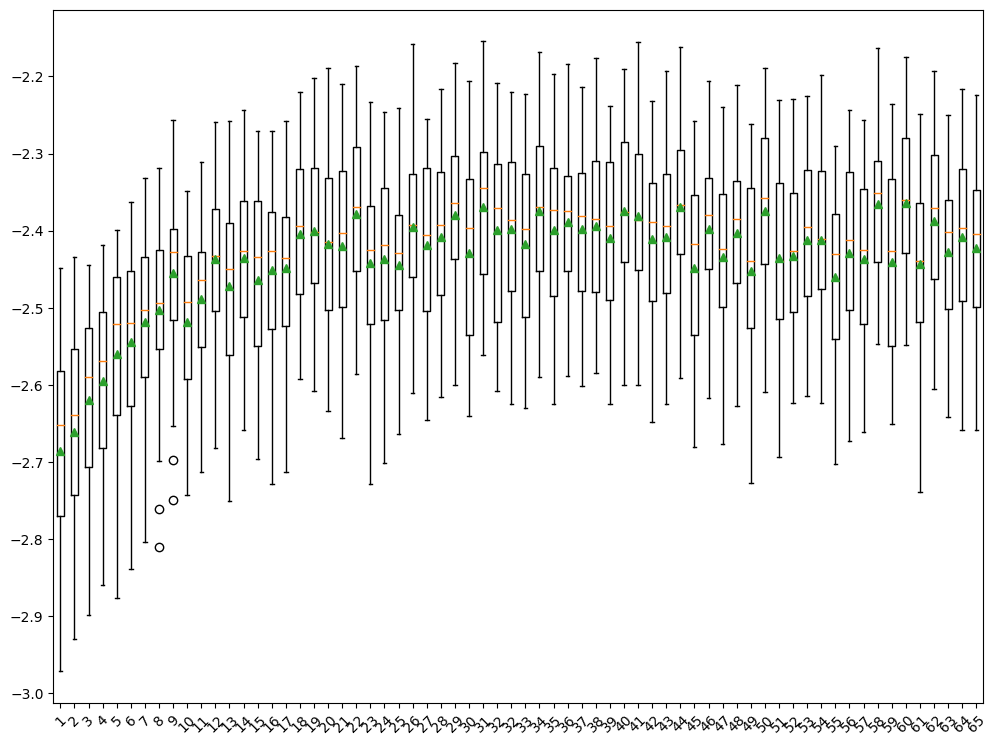

In [13]:
pyplot.figure(figsize =(12, 9))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

In [ ]:
feature_selection = ['Pathogen_212(0:n-1:y)', 'pip_resistance_202(1:sensitive-2:intermediate-3:resistant-9:not_tested)', 
                     'pip_resistance_303(1:sensitive-2:intermediate-3:resistant-9:not_tested)', 'Pathogen_508(0:n-1:y)', 
                     'pip_resistance_101(1:sensitive-2:intermediate-3:resistant-9:not_tested)', 'can_cause_sepsis_210(0:unlikely-1:probable-9:unknown)', 
                     'can_cause_sepsis_506(0:unlikely-1:probable-9:unknown)', 'Pathogen_104(0:n-1:y)', 'Pathogen_505(0:n-1:y)', 
                     'can_cause_sepsis_110(0:unlikely-1:probable-9:unknown)', 'can_cause_sepsis_303(0:unlikely-1:probable-9:unknown)', 
                     'Pathogen_205(0:n-1:y)', 'Pathogen_206(0:n-1:y)', 'Pathogen_210(0:n-1:y)', 'can_cause_sepsis_301(0:unlikely-1:probable-9:unknown)', 
                     'can_cause_sepsis_205(0:unlikely-1:probable-9:unknown)', 'Pathogen_305(0:n-1:y)', 
                     'pip_resistance_205(1:sensitive-2:intermediate-3:resistant-9:not_tested)', 
                     'pip_resistance_208(1:sensitive-2:intermediate-3:resistant-9:not_tested)', 
                     'can_cause_sepsis_106(0:unlikely-1:probable-9:unknown)', 'pip_resistance_305(1:sensitive-2:intermediate-3:resistant-9:not_tested)']